# <center> Processamento de Imagens Quânticas </center> 
## <center> Trabalho de Conclusão de Curso 2024 </center>
### <center> Universidade Federal de Lavas </center>
#### Autora: Gabriely Assunção Melo
#### Orientador: Moises Porfirio Rojas Leyva

### Bibliotecas utilizadas

In [4]:
#importando as ferramentas do qiskit
from qiskit import * 
from qiskit_aer import Aer
#importando ferramenta de visualização própria para os tipos de dados de saída do qiskit
from qiskit.visualization import plot_histogram 
#importando numpy para se trabalhar com as imagens e ferramentas matemáticas
import numpy as np
#importando matplotlib para mostrar as imagens trabalhadas
import matplotlib.pyplot as plt
#importando função para manipulação de floats
from fractions import Fraction
#importando biblioteca para manipulação de imagens
import cv2
#cor padrão do tcc em RGB
my_green = (60/256,180/256,60/256)

## Flexible Representation for Quantum Images (FRQI)
Esta representação para imagens quânticas é dada pela equação abaixo.<br>
$
|I \rangle = \frac{1}{2^{n}} \sum\limits_{i = 0}^{2^{2n}-1} |c_{i} \rangle \otimes |i \rangle 
$
<br>
em que
<br>
$
|c_{i} \rangle =  cos \theta_{i} |0 \rangle + sin \theta_{i} |1 \rangle
$
<br><br>
Na equação geral, $\theta_{i}$ varia de $[0, \frac{\pi}{2}]$ e oferece a informação relativa à intensidade dos pixeis. Nos elementos $ |i \rangle $, os valores de i são inteiros que variam de 0 à $2^{2n}-1$.
<br>
### Circuito quântico para imagem 2x2
Os qubits relativos a localização necessitam ser colocados em estado de superposição, por isso aplica-se a estes portas Hadamard. Depois para definir a intensidade de cor de cada um dos pixeis, atribui-se rotações controladas em y. 
<br>
Os dois primeiros qubits dizem respeito às coordenadas na imagem e o terceiro diz respeito às informações de intensidade dos pixels.

In [5]:
def Quantum2x2Image(thetas):
    #criação do circuito quantico com 3 qubits
    qc = QuantumCircuit(3, name = 'Image')
    #aplicando portas hadamard para colocar as portas em estado de superposição
    qc.h(0)
    qc.h(1)
    for i in range(4):
        # as portas x determinam a localização da rotação que será aplicada abs
        if i == 1 or i ==3:
            qc.x(1)
        if i == 2:
            qc.x(1)
            qc.x(0)
        # a seguir o bloco de rotação controlada para determinar a intensidade dos pixels (theta)
        qc.cry(thetas[i],0,2)
        qc.cx(0,1)
        qc.cry(-thetas[i],1,2)
        qc.cx(0,1)
        qc.cry(thetas[i],1,2)
        qc.barrier() 
    return qc

### Rodando o circuito no simulador 
A função RunSimulation tem como parâmetro a quantidade de medidas que serão realizadas sobre os qubits para se fazer análise probabilística, além do circuito que será simulado. Nela define-se o hardware da ibm que será utilizado e converte-se o circuito para melhor aplicação na topologia deste. Depois, o circuito otimizado é simulado e coleta-se os resultados das medidas.

In [6]:
def RunSimulation(QC, shots): 
    # determina o tipo de simulador que será usado
    aer_sim = Aer.get_backend('aer_simulator')
    # reescrita do circuito para coincidir com a topologia do simulador
    t_qc =  transpile(QC, aer_sim)
    # roda a simulação e coleta os resultados
    result = aer_sim.run(t_qc, shots = shots).result()
    #armazena a contagem de medidas final
    counts = result.get_counts(QC)
    return counts

No próximo bloco o usuário pode definir as intensidades de pixel que desejar para uma imagem 4x4 (qc1), indo da direita pra esqueda e de cima pra baixo. Feito isso, o código chama a função que cria a imagem e tira as devidas medidas dos qubits. Depois, a simulaçao da imagem é carregada e coleta-se os resultados em forma de histograma.

In [7]:
# lista de ângulos para a primeira imagem
thetas1 = []
for i in range(4):
    # aqui o usuário escolhe os ângulos (em graus) para cada um dos pixels 
    thetas1.append(float(input(f"Digite o ângulo {i} em graus: "))*np.pi/180)


In [8]:
qc1 = Quantum2x2Image(thetas1)
qc1.measure_all()
sim1 = RunSimulation(qc1, 20000)
plot_histogram(sim1, color = [my_green], title = 'Histograma da primeira imagem', filename = 'aa')           

O circuito pode ser melhor visualizado de forma gráfica, com as devidas portas lógicas e os ângulos de rotação. 

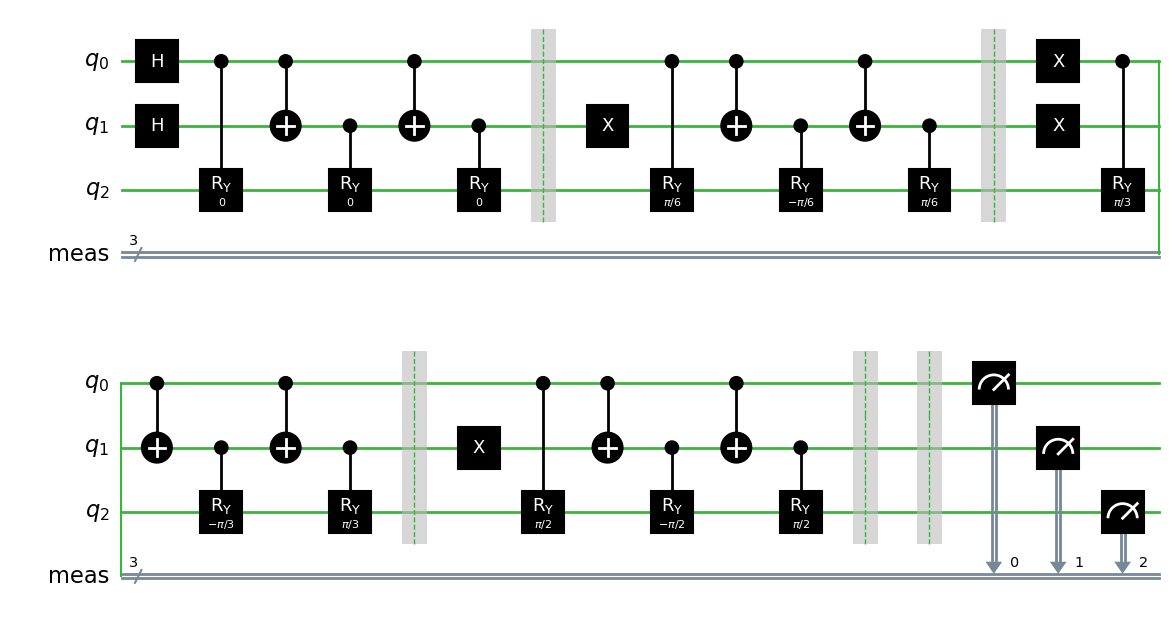

In [9]:
style = {'displaycolor':{'x':'#000000', 'cx': '#000000', 'h': '#000000', 'cry': '#000000'}, 'gatetextcolor':'#ffffff', 'linecolor': '#3CB43C'}
qc1.draw(output = 'mpl', fold = 16, style = style)

### Tratamento de dados para reconstrução da imagem clássica
A função Meas2Localization entra com as medidas tomadas (resultado da simulação) e retorna a lista das coordenadas em que foram tomadas medidas.

In [10]:
# para cada medida tomada, adiciona a uma lista os dois últimos dígitos da chave que correspondem aos dois primeiros qubits
def Meas2Localization(measures):
    localization = []
    for measurement in measures:
        loc = measurement[1]+measurement[2] 
        localization.append(loc)
    localization = list(set(localization))
    return localization

A função Meas2Intensity entra com as medidas e as coordenadas. Retorna com uma lista de intensidades normalizadas, referente a cada theta.

In [11]:
def Meas2Intensity(measure, localizations):
    loc = localizations
    # lista com as medidas de cada localização
    # dentro dessa lista serão armazenadas listas de dois elementos: as medidas de intensidade em 0 e em 1.
    prob = np.zeros((len(loc), 2))
    # declara lista com medidas totais referentes a cada localização
    shots_loc = [0, 0, 0, 0]
    # declara lista para as intensidades dos pixels 
    norm_intensity = []
    # armazena as chaves do dicionário de medidas (localizações e qubit de cores)
    keys = list(measure.keys())
    # armazena os valores do dicionário de medidas (quantidade de medidas em cada estado)
    values = list(measure.values())
    for i in range(len(measure)):
        j = 0
        # para cada uma das medidas as armazena-se em v_loc a localização da medida no estado
        v_loc = keys[i][1]+keys[i][2]
        # para cada localização na lista geral de localizações confere-se se esta é igual a localização da medida atual
        for localization in loc:
            if v_loc == localization:
                # se for igual confere se o qubit de intensidade medido é 0 ou 1 e adiciona na lista prob com index adequado
                if '0' in keys[i][0]:
                    if keys[i][0] == '0':
                        prob[j][0] += values[i]
                elif '1' in keys[i][0]:
                    if keys[i][0] == '1':
                        prob[j][1] += values[i]
            j += 1
    #depois toma-se a proporção de medidas em 0 (branco) para medidas totais em cada localização e adiciona-se na lista de intensidades
    for k in range(len(prob)):
        shots_loc[k] = prob[k][0]+prob[k][1]
        norm_intensity.append(prob[k][1]/shots_loc[k])
    return norm_intensity


A função Image2x2 requer a lista de intensidades e as localizações na ordem correta das intensidades. Retorna um array 2x2 com as intensidades. Este é a própria imagem em escala de cinza.

In [12]:
def Image2x2(intensity, localizations):
    # cria a imagem com intensidades nulas
    image = np.zeros((2, 2))
    for i in range(len(localizations)):
        #confere a localização e adicona a intensidade no local correto do array
        if localizations[i][0] == '0':
            if localizations[i][1] == '0':
                image[0][0] = intensity[i]
        if localizations[i][0] == '0':
            if localizations[i][1] == '1':
                image[1][0] = intensity[i]
        if localizations[i][0] == '1':
            if localizations[i][1] == '0':
                image[0][1] = intensity[i]
        if localizations[i][0] == '1':
            if localizations[i][1] == '1':
                image[1][1] = intensity[i]
    return image

A função PlotImage entra com os resultados da simulação e plota a imagem com seus respectivos ângulos de intensidade e registrador quântico de localização.

In [13]:
def PlotImage(simul, nome):
    #chama a função de localização
    l = Meas2Localization(simul) 
    #chama a função de intensidade
    i = Meas2Intensity(simul, l)
    # recria a imagem digital
    image = Image2x2(i, l)
    # define a figura
    plt.figure(figsize = (4, 4), facecolor = 'w')
    # define o título da figura
    #plt.title('Imagem Pós-processada') 
    # mostra a imagem de entrada na escala de cinza com intensidades normalizadas
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
    cont = 0
    for i in range(2):
        for j in range(2):
                a_pi = np.round(image[i][j]/2, 2)
                plt.text(j-0.45, i-0.3, f'\u03B8  = {Fraction(a_pi).limit_denominator(max_denominator = 1000)} \u03c0', color = my_green, fontsize = 11, weight="bold")
                plt.text(j-0.36, i-0.27, f'{cont}', color = my_green, fontsize = 7, weight="bold")
                plt.text(j-0.4, i+0.4, f'|{j}{i}>', fontsize = 11, color = my_green, weight="bold")
                cont +=1
    plt.axis('off')
    plt.savefig(nome)
    plt.show()

### Recuperando a imagem processada e seus parâmetros

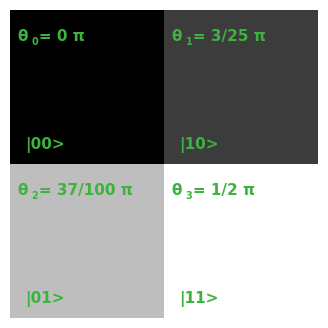

In [14]:
# plota a imagem pós-processada
PlotImage(sim1, 'im3.3.png')

## Aplicando Transformações Geométricas
As transformações geométricas nas imagens quânticas são realizadas sobre os qubits de coordenadas. Como neste trabalho estam sendo tratadas imagens de menor dimensão possível, as transformações aplicadas são transformações globais. 
### Flip em X
Para espelhar a imagem em X basta aplicar a porta lógica quântica NOT sobre os qubits componentes da coordenada em X. 
<br>
$F^{X}_{I}(|I \rangle) = \frac{1}{2^{n}} \sum\limits_{k = 0}^{2^{2n}-1}|c_{k} \rangle \otimes (|\overline{y}x \rangle)$

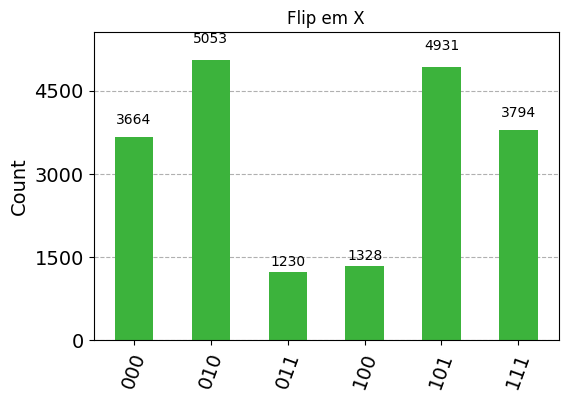

In [15]:
qc2 = Quantum2x2Image(thetas1)
qc2.x(1)
qc2.measure_all()
flip_x = RunSimulation(qc2, 20000)
plot_histogram(flip_x, color = [my_green], figsize = (6, 4), title = 'Flip em X')

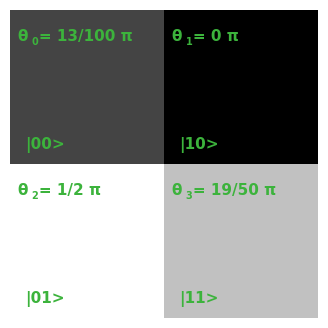

In [16]:
# plota a imagem pós-processada
PlotImage(flip_x, 'im3.4.png')

### Flip em Y
Para espelhar a imagem em Y basta aplicar a porta lógica quântica NOT sobre os qubits componentes da coordenada em Y. 
<br>
$F^{Y}_{I}(|I \rangle) = \frac{1}{2^{n}} \sum\limits_{k = 0}^{2^{2n}-1}|c_{k} \rangle \otimes (|y \overline{x} \rangle)$

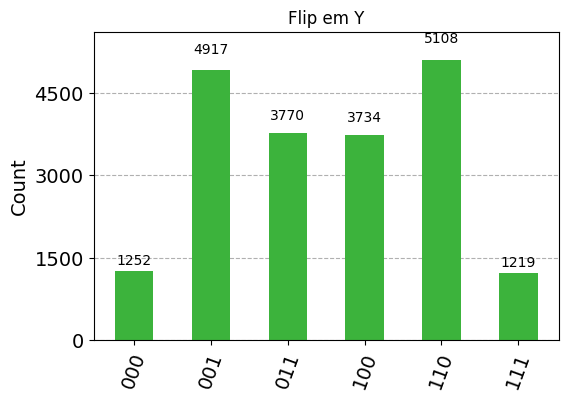

In [17]:
qc3 = Quantum2x2Image(thetas1)
qc3.x(0)
qc3.measure_all()
flip_y = RunSimulation(qc3, 20000)
plot_histogram(flip_y, color = [my_green], figsize = (6, 4), title = 'Flip em Y')

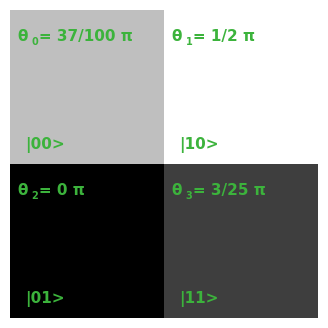

In [18]:
# plota a imagem pós-processada
PlotImage(flip_y, 'im3.5.png')

### Troca de coordenadas
A troca de coordenadas é feita com a inversão de todos os qubits de coordenadas. Ou seja, troca os valores de X e Y. <br>
Para isso, aplica-se a porta lógica quântica SWAP. Esta faz com que o espelhamento seja diagonal, sem interferência nos elementos da diagonal principal, já que neles as coordenadas X e Y são idênticas.

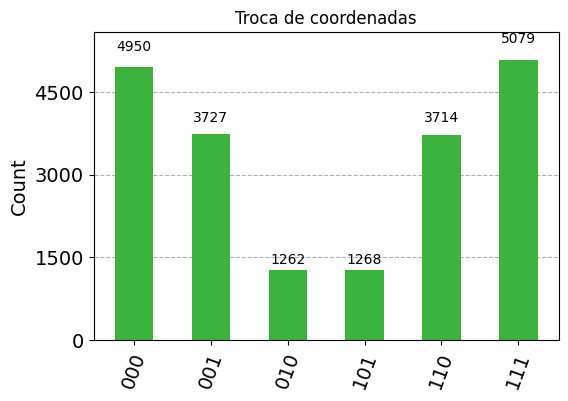

In [19]:
qc4 = Quantum2x2Image(thetas1)
qc4.swap(0, 1)
qc4.measure_all()
swap = RunSimulation(qc4, 20000)
plot_histogram(swap, color = [my_green], figsize = (6, 4), title = 'Troca de coordenadas')

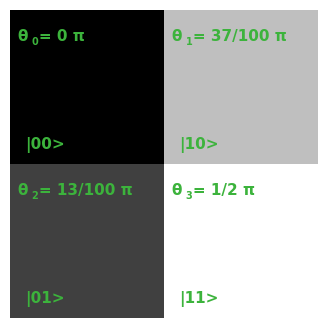

In [20]:
# plota a imagem pós-processada
PlotImage(swap, 'im3.6.png')

## Transformações de cores
As transformações de cores ocorrem sobre o qubit relacionado a intensidade de cores. Estas, aqui apresentadas, são transformações globais, que modificam a intensidade dos pixeis da imagem como um todo uniformemente.
### Inversão de cor (NOT -$\pi$)
Para inversão de cores da imagem deve-se defasar o ângulo de rotação do qubit em $\pi$ radianos. Dessa forma, basta aplicar a porta NOT.

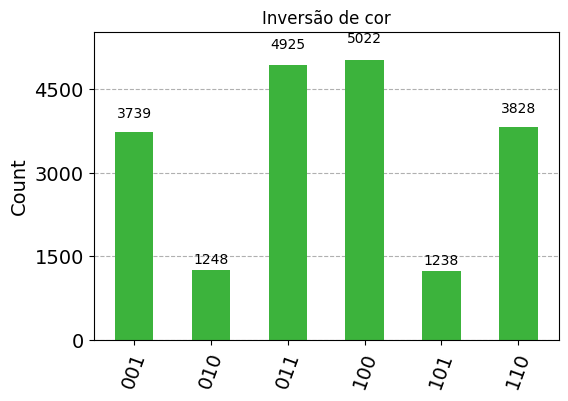

In [21]:
qc5 = Quantum2x2Image(thetas1)
qc5.x(2)
qc5.measure_all()
c_inv = RunSimulation(qc5, 20000)
plot_histogram(c_inv, color = [my_green], figsize = (6, 4), title = 'Inversão de cor')

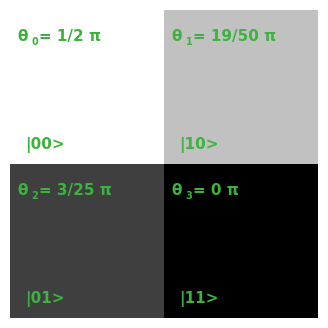

In [22]:
# plota a imagem pós-processada
PlotImage(c_inv, 'im3.7.png')

### Neutralização (Hadamard -$\frac{\pi}{2}$)
A operação de neutralização de cores serve para uniformizar e abrandar a intensidade dos pixels. Nesse sentido, utiliza-se uma defasagem de $\frac{\pi}{2}$ no qubit de cor, a partir da porta lógica Hadamard.

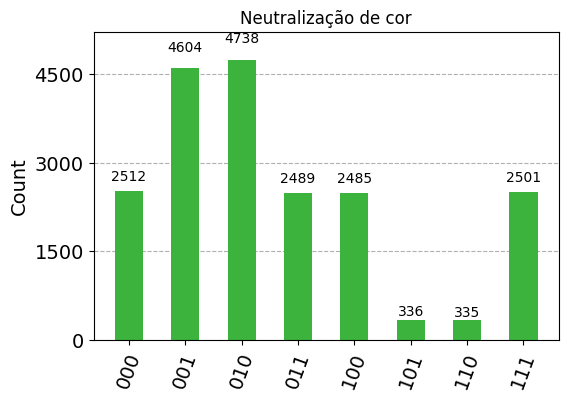

In [23]:
qc6 = Quantum2x2Image(thetas1)
qc6.h(2)
qc6.measure_all()
c_neg = RunSimulation(qc6, 20000)
plot_histogram(c_neg, color = [my_green], figsize = (6, 4), title = 'Neutralização de cor')

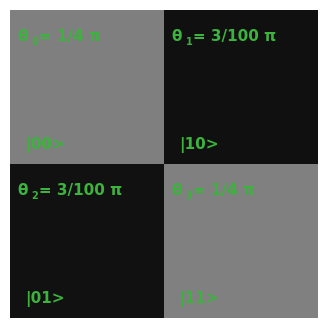

In [24]:
# plota a imagem pós-processada
PlotImage(c_neg, 'im3.8.png')

### Transformadas de cores genéricas
As transformadas de cores globais para esse tipo de representação são geralmente realizadas a partir da rotação do angulo com relação ao eixo z na esfera de Bloch. Assim, para se alterar a intensidade da imagem de forma genérica basta aplicar rotações genéricas no eixo y da esfera de Bloch. 

In [25]:
qc7 = Quantum2x2Image(thetas1)
qc7.ry(-np.pi/8, 2)
qc7.measure_all()
c_gen1 = RunSimulation(qc7, 20000)
qc8 = Quantum2x2Image(thetas1)
qc8.ry(np.pi/6, 2)
qc8.measure_all()
c_gen2 = RunSimulation(qc8, 20000)
qc9 = Quantum2x2Image(thetas1)
qc9.ry(-np.pi/2, 2)
qc9.measure_all()
c_gen3 = RunSimulation(qc9, 20000)
plot_histogram([c_gen1, c_gen2, c_gen3], filename = 'im4.9.png', color = [my_green, (60/256,200/256,60/256), (60/256,256/256,60/256)], bar_labels = False, figsize = (10, 6), title = 'Transformada de cor genérica', legend = ['\u03c0 /8','\u03c0 /6','\u03c0 /4'])

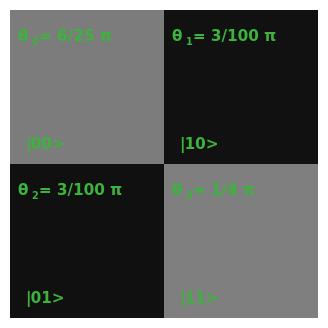

In [26]:
PlotImage(c_gen3, 'im4.11.png')

## Teleporte Quântico de um estado de 3 qubits
### Preparando a imagem que será teleportada
Aqui define-se e apresenta-se uma imagem a ser teleportada.

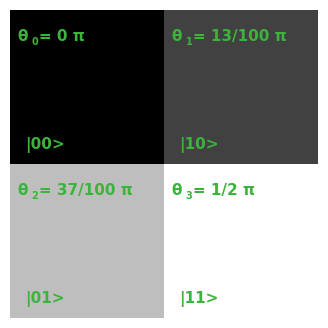

In [27]:
image = Quantum2x2Image([0*np.pi/180, 30*np.pi/180, 60*np.pi/180, 90*np.pi/180])
image.measure_all()
results = RunSimulation(image, 20000)
image.remove_final_measurements()
# plota a imagem pós-processada
PlotImage(results, 'im4.12.png')

### Circuito quântico de teleporte
Antes de criar o circuito do teleporte, cria-se os registradores. Como serão teleportados os estados de 3 qubits, são necessários 3 registradores quânticos para Alice e 3 para Bob. Além disso, 3 registradores quanticos são declarados para armazenar a imagem. Depois, chama-se os registradores clássicos para se realizar medidas nos qubits da Alice e nos qubits da imagem original. <br>
Então o circuito é criado com estes registradores e a imagem preparada já é adicionada em seu devido local.<br>
Ressalta-se aqui que o protocolo realizado aqui é o protocolo de teleporte quântico mais trivial e portanto ainda é necessário canais clássicos para que os estados do Bob sejam manipulados corretamente.<br>


In [28]:
im = QuantumRegister(3, 'Image')
a = QuantumRegister(3, 'Alices')
b = QuantumRegister(3, 'Bobs')
m = ClassicalRegister(6, 'Measurements')
telcir = QuantumCircuit(im, a, b, m)
telcir.append(image.to_instruction(), im)

Agora, para cada qubit a ser teleportado tem-se um par Alice e Bob. Em cada um desses, constroi-se um estado emaranhado de Bell, utilizando as portas lógicas quânticas NOT controlada e Hadamard

In [29]:
for i in range(3):
    telcir.barrier()
    telcir.h(a[i])
    telcir.cx(a[i], b[i])
    telcir.cx(im[i], a[i])
    telcir.h(im[i])
    telcir.measure(a[i], m[i])
    telcir.measure(im[i], m[i+3])
    with telcir.if_test((m[i], 1), label = 'x'):
        telcir.x(b[i])
    with telcir.if_test((m[i+3], 1), label = 'z'):
        telcir.z(b[i])


c:\Users\gabri\anaconda3\envs\tcc\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


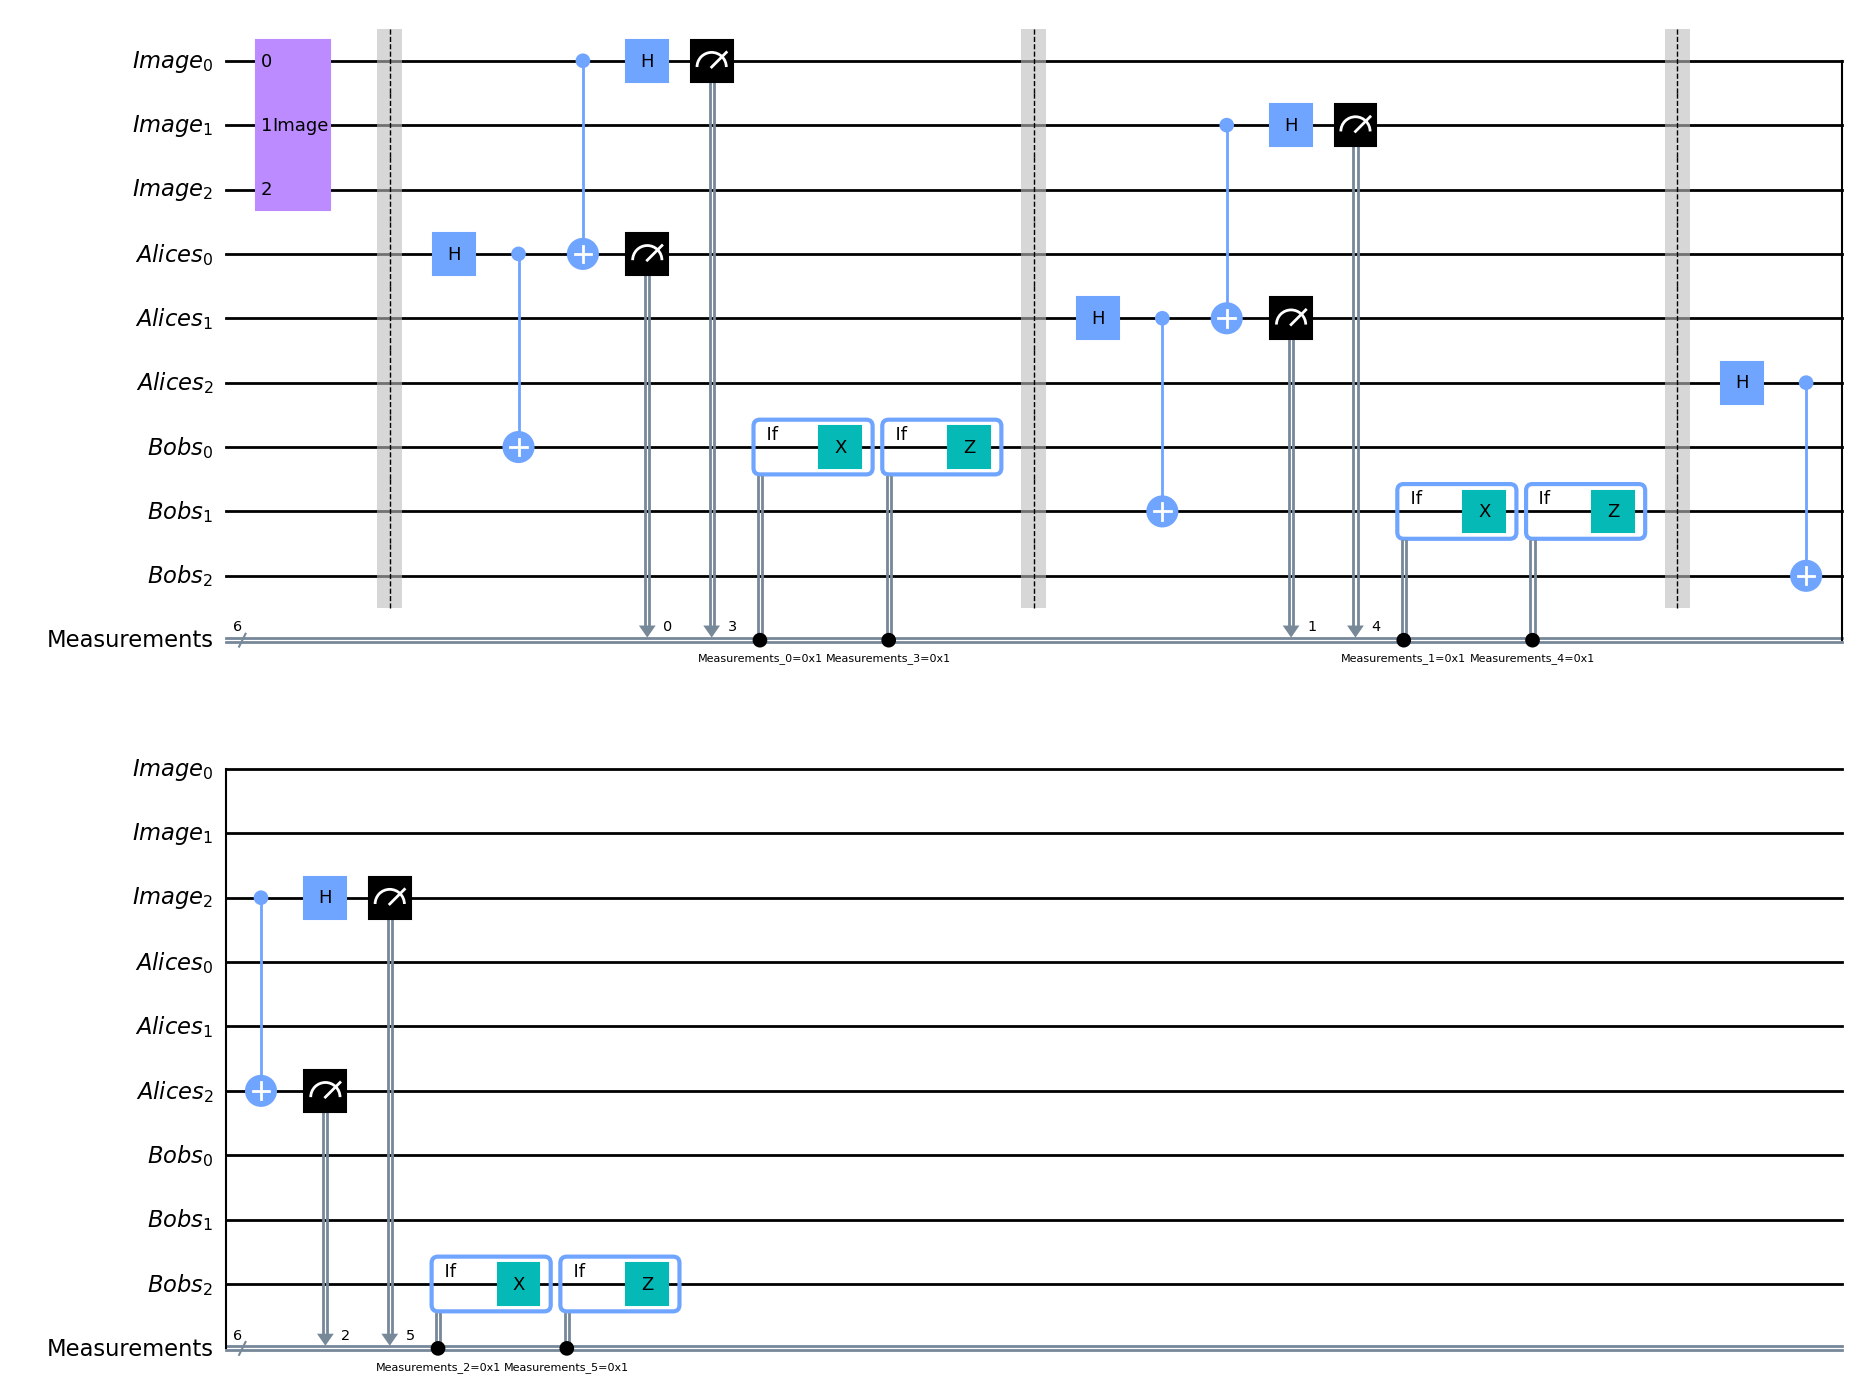

In [30]:
telcir.draw(output = 'mpl')

### Recuperando imagem teleportada

In [31]:
tel_im = ClassicalRegister(3, 'Teleported image')
telcir.add_register(tel_im)
telcir.measure(b, tel_im)

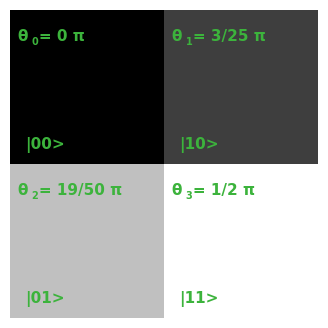

In [32]:
r = RunSimulation(telcir, 20000)
# plota a imagem pós-processada
PlotImage(r, 'tel1.png')

## Teleportando imagem clássica via convolução

In [33]:
def ShowImage(img, title):
    plt.figure(figsize=[10,10],facecolor = 'w')
    plt.title(title, color = 'k')
    plt.imshow(img, cmap = plt.get_cmap('grey'), vmin =0, vmax = 255)
    plt.axis('off')
    plt.savefig(title, dpi= 500)
    plt.show()

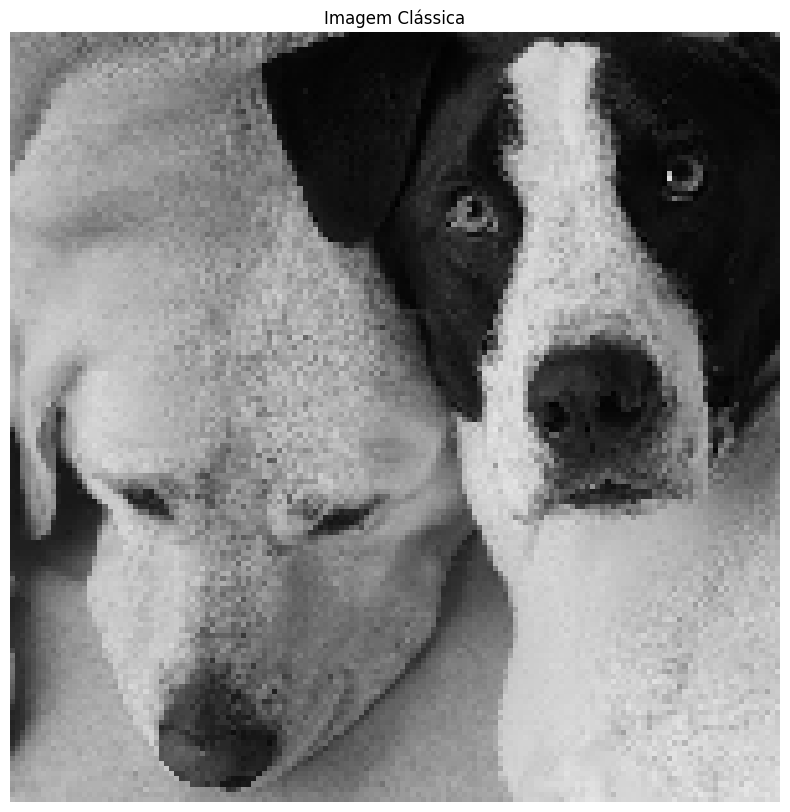

In [34]:
imagem = cv2.imread("dogs_classica.png")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
imagem = cv2.resize(imagem, (150, 150), interpolation = cv2.INTER_LINEAR)
cv2.imwrite('resized_dogs.png', imagem)
ShowImage(imagem, 'Imagem Clássica')

In [35]:
def TeleportingImage(image):
    im = QuantumRegister(3, 'Image')
    a = QuantumRegister(3, 'Alices')
    b = QuantumRegister(3, 'Bobs')
    m = ClassicalRegister(6, 'Measurements')
    telcir = QuantumCircuit(im, a, b, m)
    telcir.append(image.to_instruction(), im)
    for i in range(3):
        telcir.barrier()
        telcir.h(a[i])
        telcir.cx(a[i], b[i])
        telcir.cx(im[i], a[i])
        telcir.h(im[i])
        telcir.measure(a[i], m[i])
        telcir.measure(im[i], m[i+3])
        with telcir.if_test((m[i], 1)):
            telcir.x(b[i])
        with telcir.if_test((m[i+3], 1)):
            telcir.z(b[i])
    tel_im = ClassicalRegister(3, 'Teleported image')
    telcir.add_register(tel_im)
    telcir.measure(b, tel_im)
    t_im = RunSimulation(telcir, 20000)
    loc = Meas2Localization(t_im) 
    inte = Meas2Intensity(t_im, loc)
    final_im = Image2x2(inte, loc)
    #print(final_im)
    return final_im

In [36]:
def SaveArq(tel_result, path):
    im_text = np.array2string(tel_result).strip()
    im_text = im_text.replace('[', '')
    im_text = im_text.replace(']', '')
    with open(path, 'a') as arquivo:
        arquivo.write(f'{im_text} \n')

In [11]:
# i = 0
# cont_im = 0 
# new_image = np.zeros((np.shape(imagem)[1], np.shape(imagem)[0]))
# path = str(input('Digite o nome do novo arquivo:'))
# path = 'Teleported_Images\\' + path + '.txt'
# arq = open(path, 'x')
# while i < len(imagem):
#     j = 0
#     cont_im += 1
#     print(cont_im)
#     while j < len(imagem[i]):
#         q = (np.squeeze(np.reshape(np.array([[imagem[i][j], imagem[i][j+1]],[imagem[i+1][j], imagem[i+1][j+1]]]), (1, 4))*(np.pi/2)/255))
#         r = TeleportingImage(Quantum2x2Image(q))
#         SaveArq(r, path)
#         j += 2 
#     i += 2

In [38]:
images = []
readline = []
path = 'dogs_vai.txt'
with open(path, 'r') as arquivo:
    cont = 0
    for line in arquivo:
        readline.append(np.fromstring(line, dtype = float, count = -1, sep = ' '))
        cont += 1
        if cont == 2:
            im = np.row_stack((readline[0], readline[1]))
            images.append(im)
            cont = 0
            readline = []



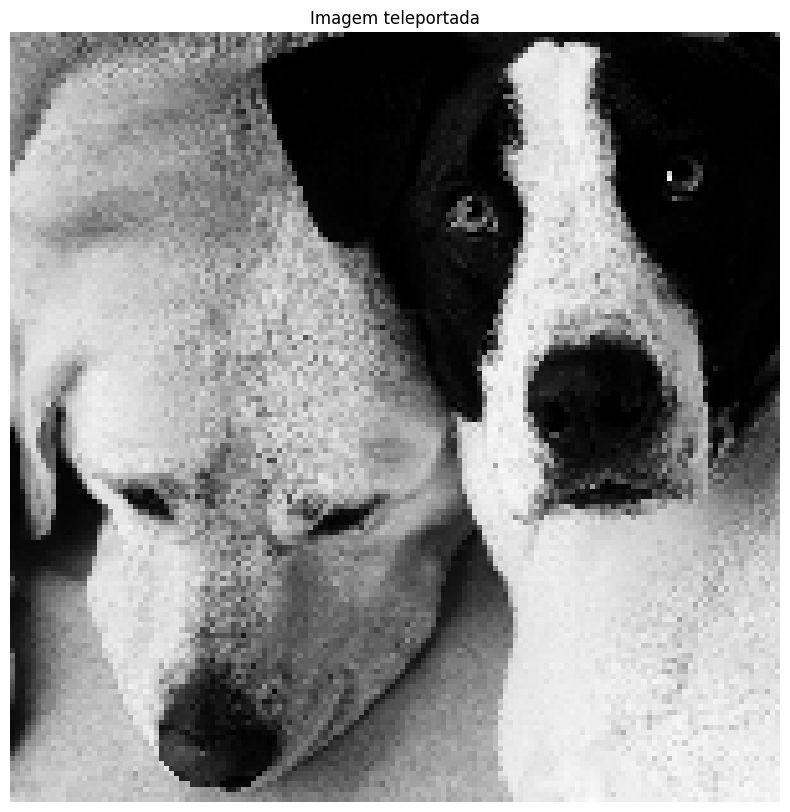

In [39]:
fila = []
for i in range(int(np.shape(imagem)[1]/len(images[0][1]))):
    tel_image = images[i*int(np.shape(imagem)[1]/len(images[0][1]))]
    for j in range(1, int(np.shape(imagem)[0]/len(images[0][0]))):
        tel_image = np.concatenate((tel_image, images[i*int(np.shape(imagem)[1]/len(images[0][1]))+j]), axis = 1)
    fila.append(tel_image) 
final_image = fila[0]
for k in range(1, len(fila)):
    final_image = np.concatenate((final_image, fila[k]), axis = 0)
final_image = final_image*255
final_image = final_image.astype(int)
ShowImage(final_image, 'Imagem teleportada')


In [40]:
import numpy as np
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
img1 = imagem
img2 = final_image

def calculate_ssim_and_mse(image1, image2, win_size=7):
    # Calcular o SSIM entre as duas imagens com o tamanho de janela especificado
    ssim_index, _ = ssim(image1, image2, win_size=win_size, full=True)
    
    # Calcular o MSE entre as duas imagens
    mse_value = mean_squared_error(image1, image2)
    
    # Calcular a variância dos dados verdadeiros
    variance = np.var(image1)
    
    # Calcular o NMSE
    nmse_value = mse_value / variance if variance != 0 else float('inf')
    
    # Calcular o RMSE
    rmse_value = np.sqrt(mse_value)
    
    return ssim_index, mse_value, nmse_value, rmse_value

ssim_value, mse_value, nmse_value, rmse_value = calculate_ssim_and_mse(img1, img2, win_size=149)

print(f'Valor do SSIM: {ssim_value}')
print(f'Valor do MSE: {mse_value}')
print(f'Valor do NMSE: {nmse_value}')
print(f'Valor do RMSE: {rmse_value}') 

Valor do SSIM: 0.9689833593352045
Valor do MSE: 373.89546666666666
Valor do NMSE: 0.08237755245874374
Valor do RMSE: 19.33637677194636


C:\Users\gabri\AppData\Local\Temp\ipykernel_37552\1918825676.py:10: UserWarning: Inputs have mismatched dtypes. Setting data_range based on im1.dtype.
  ssim_index, _ = ssim(image1, image2, win_size=win_size, full=True)
